# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd #импортируем нужные нам библиотеки
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,confusion_matrix
from scipy import stats as st
from numpy.random import RandomState
import matplotlib.pyplot as plt
import itertools 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
df = pd.read_csv('/datasets/geo_data_0.csv')
df.describe()

,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


In [3]:
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_1.describe()

,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


In [4]:
df_2 = pd.read_csv('/datasets/geo_data_2.csv')
df_2.describe()

,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Загрузим и посмотрим на наши датасеты методами info и describe. Видно что значение в парметров f0 и f1 сильно отличаются во втором датасете, по сравнению с двумя другими , а учитывая что и запасы нефти в нем еще и меньше, вряд ли этот регион даст нам максимальную прибыль, но это узнаем позже). Пропусков d  наших данных нет, проверим их на дубликаты.

In [8]:
print(df['id'].duplicated(keep='first').sum())
print(df.duplicated(keep='first').sum())
print(df_1['id'].duplicated(keep='first').sum())
print(df_1.duplicated(keep='first').sum())
print(df_2['id'].duplicated(keep='first').sum())
print(df_2.duplicated(keep='first').sum())

10
0
4
0
4
0


Как видим явных дубликатов нет, есть небольшое количество дубликатов по id — уникальному идентификатору скважины, но возможно это связано с нескольками замерами на одной и той же скважине. В любом случае их очень мало и удалять их нет смысла).Теперь посмотрим на корреляцию и ковариацию данных.

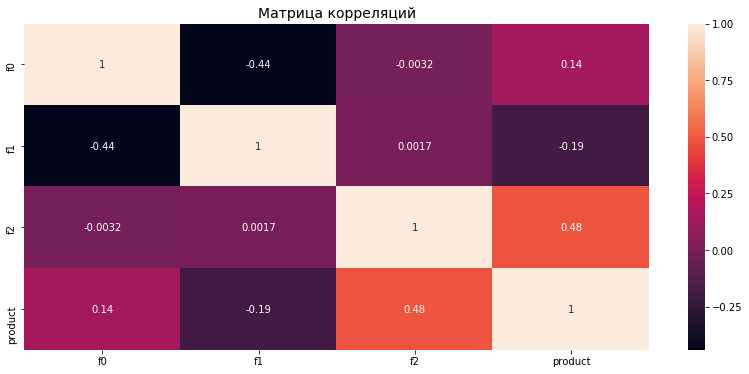

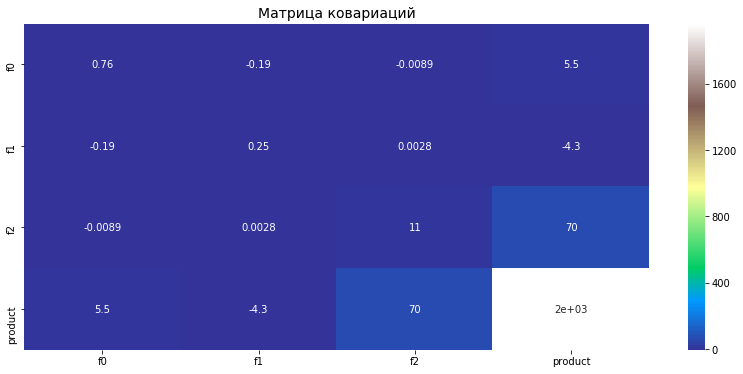

In [9]:
corr_matrix = df.drop(['id'], axis=1).corr()
plt.figure(figsize=(14,6))
plt.title('Матрица корреляций', fontsize=14)
sns.heatmap(corr_matrix,annot=True)
plt.figure(figsize=(14,6))
plt.title('Матрица ковариаций', fontsize=14)
sns.heatmap(df.cov(),annot=True,cmap='terrain')

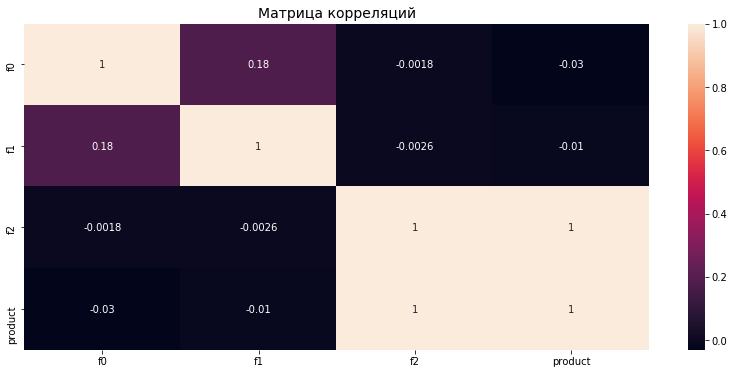

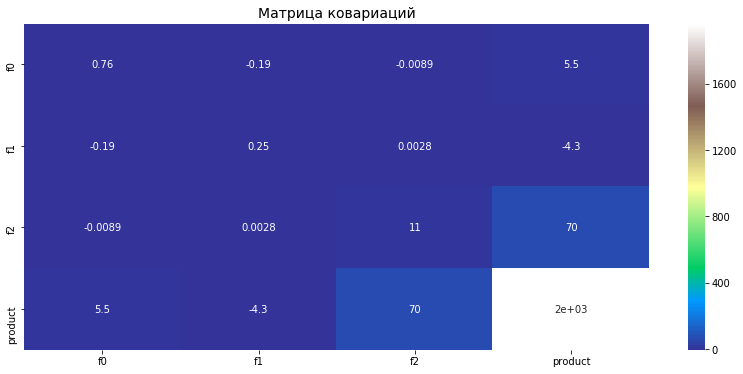

In [10]:
corr_matrix = df_1.drop(['id'], axis=1).corr()
plt.figure(figsize=(14,6))
plt.title('Матрица корреляций', fontsize=14)
sns.heatmap(corr_matrix,annot=True)
plt.figure(figsize=(14,6))
plt.title('Матрица ковариаций', fontsize=14)
sns.heatmap(df.cov(),annot=True,cmap='terrain')

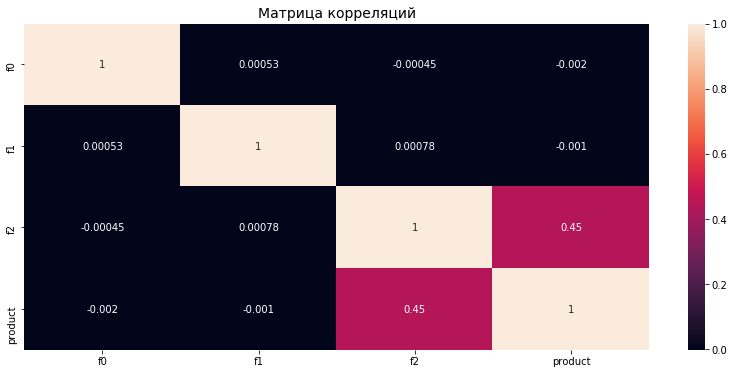

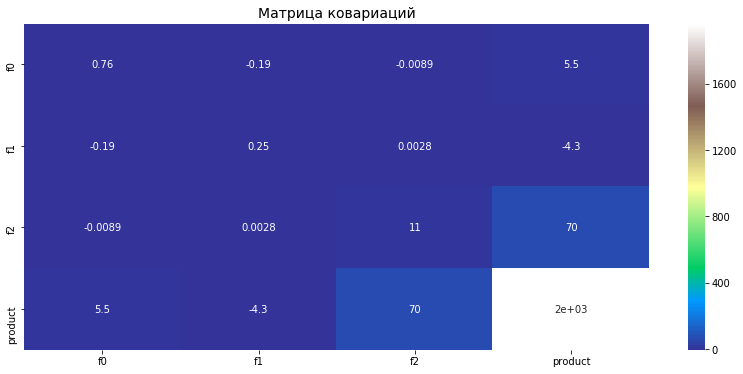

In [11]:
corr_matrix = df_2.drop(['id'], axis=1).corr()
plt.figure(figsize=(14,6))
plt.title('Матрица корреляций', fontsize=14)
sns.heatmap(corr_matrix,annot=True)
plt.figure(figsize=(14,6))
plt.title('Матрица ковариаций', fontsize=14)
sns.heatmap(df.cov(),annot=True,cmap='terrain')

Существует кореляция между признаком f2 и product около 0,5 в  первом и третьем датасете и 100 % во втором, поэтому мы можем его удалить.(но сделаем это чуть позже)

Посмотрим каковы выбросы в наших регионах, для этого построим диаграмму размаха для наших признаков.

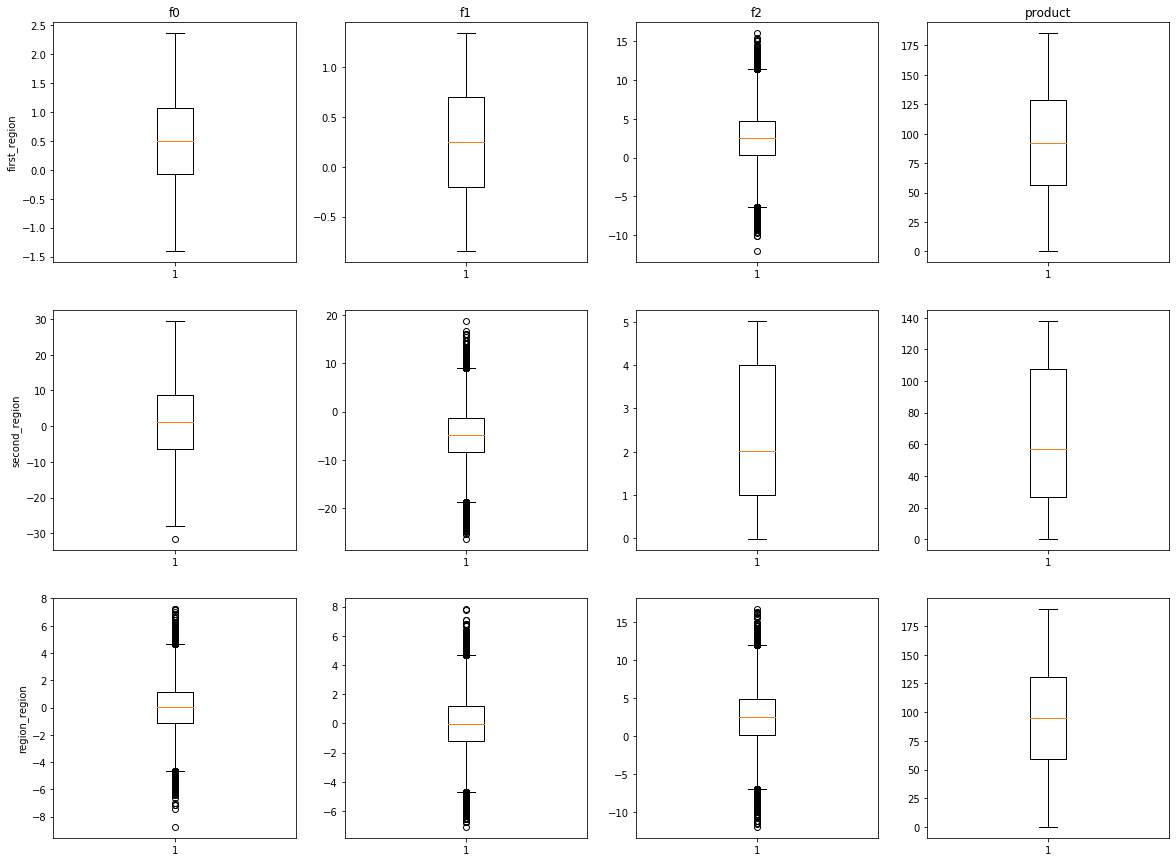

In [12]:
fig,ax = plt.subplots(3,4,figsize = (20,15))

region = ['first_region','second_region',"region_region"]
name_column = df.columns[1:]
name_column_with_columns = zip(df.columns[1:],range(4))
df_with_rows = zip([df,df_1,df_2],range(3))
for column in list(itertools.product(df_with_rows,name_column_with_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]])
for row in range(3): # Добавим название региона на графике
    ax[row][0].set_ylabel(region[row])
for column in range(4): # Добавим название параметра скважины на графике
    ax[0][column].set_title(name_column[column])


Мы видим выбросы для параметра f2 в первом регионе, f1 для второго региона, и для всех параметров в третьем регионе. напишем функцию для удаления выбросов . Сначала посчитаем 0,25 и 0,75 кванитили(которые уже и так посчитаны в describe:))и умножим их на 1,5 чтобы опредилить границы "усов". Затем запишем индесы с выбросами анализируемых нами параметров и проверим их длину .На выход передадим массив с индесами строк с выбросами

In [13]:
def remove_release(dfs,columns):
    q25=np.array(dfs[columns].quantile(0.25))
    
    q75=np.array(dfs[columns].quantile(0.75))
    first_part=q25-1.5*(q75-q25)
    second_part=q75+1.5*(q75-q25)
    del_index = []
    for index_value, value in zip(dfs[columns].index,dfs[columns]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    
    print('Количество строк, выбранных для удаления: ',len(del_index))
    return del_index

Передадим в переменную release (выбросы) значения параметров и датафремов с выбросами, за исключение f2 из df_2,который мы и так решили удалить)).

In [14]:
release = [(df,'f2'),(df_1,'f1'),(df_2,'f0'),(df_2,'f1')]
for data,column in release:
    indexes = remove_release(data,column)
    data.drop(indexes,axis = 0,inplace = True)


Количество строк, выбранных для удаления:  506
Количество строк, выбранных для удаления:  636
Количество строк, выбранных для удаления:  733
Количество строк, выбранных для удаления:  682


Количество выбросов незначительно, качество наших датасетов сильно не пострадает.Тепреь можно и удалить скореллированный столбец f2 из df_2.

In [15]:
df = df.reset_index(drop = True)
df_1 = df_1.reset_index(drop = True)
df_2 = df_2.reset_index(drop = True)

Проверим, все ли получилось)

In [16]:
df.describe()

,f0,f1,f2,product
count,"99,494.00","99,494.00","99,494.00","99,494.00"
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.18,44.23
min,-1.41,-0.85,-6.35,0.00
25%,-0.07,-0.20,0.30,56.57
50%,0.50,0.25,2.52,91.84
75%,1.07,0.70,4.70,128.52
max,2.36,1.34,11.35,185.36


In [17]:
df_2.describe()

,f0,f1,f2,product
count,"98,585.00","98,585.00","98,585.00","98,585.00"
mean,0.00,-0.00,2.49,94.76
std,1.68,1.68,3.47,44.74
min,-4.64,-4.68,-11.97,0.00
25%,-1.15,-1.16,0.13,59.25
50%,0.01,-0.01,2.48,94.66
75%,1.15,1.15,4.86,130.36
max,4.64,4.67,16.74,190.03


In [18]:
#drop_df_1 = df_1.drop(['f2'],axis = 1) #удалим скорелированный  столбец f2

In [19]:
#drop_df_1.describe()
df_1.describe()

,f0,f1,f2,product
count,"99,364.00","99,364.00","99,364.00","99,364.00"
mean,1.14,-4.80,2.49,68.81
std,8.97,4.98,1.70,45.93
min,-31.61,-18.67,-0.02,0.00
25%,-6.30,-8.25,1.00,26.95
50%,1.15,-4.82,2.01,57.09
75%,8.62,-1.36,4.00,107.81
max,29.42,9.05,5.02,137.95


Данные подготовлены, можно строить модели)

## Обучение и проверка модели

Построим модель для первого региона, подготовим выборки, посчитаем RMSE.

In [20]:
features = df.drop(['id','product'], axis = 1)
target = df['product']

In [21]:
features_train,features_valid,target_train,target_valid = train_test_split(features,target,test_size = 0.25,random_state = 12345)

In [22]:
for i in features_train, features_valid, target_train,target_valid :
    print(f'Длина ',len(i))

Длина  74620
Длина  24874
Длина  74620
Длина  24874


На всякий случай посмотрим что вышло) и после этого отмасштабируем признак f2

In [23]:
numeric = ['f2']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_train.describe()

,f0,f1,f2
count,"74,620.00","74,620.00","74,620.00"
mean,0.50,0.25,0.00
std,0.87,0.50,1.00
min,-1.41,-0.85,-2.78
25%,-0.08,-0.20,-0.69
50%,0.50,0.25,0.00
75%,1.07,0.70,0.69
max,2.33,1.34,2.78


In [24]:
model = LinearRegression()
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

In [25]:
rmse = mean_squared_error(target_valid, predicted_valid)**0.5
print("Регион 1 RMSE =", rmse)
print('Средний запас регион 1:',predicted_valid.mean())

Регион 1 RMSE = 37.922930890531454
Средний запас регион 1: 92.72476770114889


Сделаем тоже для второго региона.

In [26]:
#features_1 = drop_df_1.drop(['id','product'], axis = 1)
#target_1 = drop_df_1['product']
features_1 = df_1.drop(['id','product'], axis = 1)
target_1 = df_1['product']
features_train_1,features_valid_1,target_train_1,target_valid_1 = train_test_split(features_1,target_1,test_size = 0.25,random_state = 12345)
numeric = ['f0','f1']
scaler.fit(features_train[numeric])
features_train_1[numeric] = scaler.transform(features_train_1[numeric])
features_valid_1[numeric] = scaler.transform(features_valid_1[numeric])
features_train_1.describe()
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
predicted_valid_1 = model_1.predict(features_valid_1)
rmse_1 = mean_squared_error(target_valid_1, predicted_valid_1)**0.5
print("Регион 2 RMSE =", rmse_1)
print('Средний запас регион 2:',predicted_valid_1.mean())

Регион 2 RMSE = 0.889447814640159
Средний запас регион 2: 68.59166978153503


И для последнего, третьего региона.

In [27]:
features_2 = df_2.drop(['id','product'], axis = 1)
target_2 = df_2['product']
features_train_2,features_valid_2,target_train_2,target_valid_2 = train_test_split(features_2,target_2,test_size = 0.25,random_state = 12345)
numeric = ['f2']
scaler.fit(features_train[numeric])
features_train_2[numeric] = scaler.transform(features_train_2[numeric])
features_valid_2[numeric] = scaler.transform(features_valid_2[numeric])
features_train_2.describe()
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
predicted_valid_2 = model_2.predict(features_valid_2)
rmse_2 = mean_squared_error(target_valid_2, predicted_valid_2)**0.5
print("Регион 3 RMSE =", rmse_2)
print('Средний запас регион 3:',predicted_valid_2.mean())

Регион 3 RMSE = 40.10443310893119
Средний запас регион 3: 95.03338341499384


В первом регионе среднеквадратическая ошибка меньше всего, но по среднему объему запасов регион на втором месте.
Второй регион как мы и предполагили в аутсайдерах по запаса и дает самую большую ошибку. Третий регион имеет самый большой средний объем запасов, но по среднеквадратической ошибке на втором месте.

## Подготовка к расчёту прибыли

Зная стоимость барреля, количество буровых скважин и общий бюджет на их разработку посчитаем минимальное количество запасов нефти в одной скважине при котором разработка будет не убыточной.

In [28]:
region_budget = 10000000000
total_boreholes = 500
final_boreholes = 200
barrel_price = 450
loss_probability =  0.025
non_loss_probability = (region_budget/(barrel_price*1000))/final_boreholes
display(non_loss_probability)

111.11111111111111

Минимальное количество тысяч тонн баррелей нефти для безубыточной разработки составило 111.(1)

In [29]:
print('Процент прибыльных для разработки скважин в 1 регионе', round(len(df.query('product > 111.112'))*100/len(df),2) )
#print('Процент прибыльных для разработки скважин во 2 регионе', round(len(drop_df_1.query('product > 111.112'))*100/len(df),2) )
print('Процент прибыльных для разработки скважин во 2 регионе', round(len(df_1.query('product > 111.112'))*100/len(df),2) )
print('Процент прибыльных для разработки скважин в 3 регионе', round(len(df_2.query('product > 111.112'))*100/len(df),2) )

Процент прибыльных для разработки скважин в 1 регионе 36.54
Процент прибыльных для разработки скважин во 2 регионе 16.5
Процент прибыльных для разработки скважин в 3 регионе 37.66


Первый и третий регион по прежнему привлекательнее, хотя среднее зачения в этих регионах ниже точки безубыточности, но они почти в 1,5 раза больше среднего во втором регионе.

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [30]:
def income(true_target, predicted_target):
    sort_boreholes = pd.Series(predicted_target).sort_values(ascending=False)[:final_boreholes]
    true_target_sort = true_target.reset_index(drop = True)[sort_boreholes.index]
    sum_true = true_target_sort.sum() 
    return round((sum_true* barrel_price*1000) - region_budget,2 )

In [31]:
print("Прибыль с лучших 200 скважин в первом регионе:",income(target_valid ,predicted_valid))
print("Прибыль с лучших 200 скважин во втором регионе:",income(target_valid_1 ,predicted_valid_1))
print("Прибыль с лучших 200 скважин в третьем регионе:",income(target_valid_2 ,predicted_valid_2))

Прибыль с лучших 200 скважин в первом регионе: 3346905536.45
Прибыль с лучших 200 скважин во втором регионе: 2415086696.68
Прибыль с лучших 200 скважин в третьем регионе: 2662703635.38


Посчитаем риски и прибыль для каждого региона, оформим это в виде функции в которой применим технику Bootstrap с 1000 выборок, а для подсчета прибыли используем написааную  ранее функцию income. Риск убытков это доля всех скважин с отрицательным значений прибыли от их общего числа.

In [32]:
 def confidence_interval(true_target, predicted_target):
    state = RandomState(100)    
    values = []
    for i in range(1000):
        value = pd.Series(predicted_target).sample(n = total_boreholes, replace=True, random_state=state)
        values.append(income(true_target,value))
    values = pd.Series(values)
    print('Cредняя прибыль',values.mean())
#    print('Риск убытков',values.apply(lambda x: x < 0).sum()/len(values)*100,"%" )
    print(f"Риск убытков {(values<0).mean()}")
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
#    confidence_interval = st.t.interval(0.95, len(values)-1,values.mean(),values.sem()) № так красиво), но нам не подходит))
#    print("95%-ый доверительный интервал:", confidence_interval)
    return round(lower,2), round(upper,2)

In [33]:
print("95% доверительный интервал для  региона 1 лежит между:",confidence_interval(target_valid ,predicted_valid))
print("95% доверительный интервал для  региона 2 лежит между:",confidence_interval(target_valid_1 ,predicted_valid_1))
print("95% доверительный интервал для  региона 3 лежит между:",confidence_interval(target_valid_2 ,predicted_valid_2))

Cредняя прибыль 374431684.19216
Риск убытков 0.073
95% доверительный интервал для  региона 1 лежит между: (-152670573.89, 865680639.01)
Cредняя прибыль 452598364.23249
Риск убытков 0.008
95% доверительный интервал для  региона 2 лежит между: (70989574.69, 820230104.87)
Cредняя прибыль 359439885.97696996
Риск убытков 0.102
95% доверительный интервал для  региона 3 лежит между: (-175748101.36, 906452946.8)


Оказалось мы ошиблись при первичном анализе, регион 2 оказался самым переспективным,  вероятностью убытка там всего лишь 0,8% н. Первый и третий регион не подходят нашим условиям .